# 前提条件

| 項目   | 内容                           |
|------|------------------------------|
| 概要   | 顧客満足度アンケートの Data             |
| 対象期間 | 2019年１月 ~ ４月                 |
| 保存方法 | Database                     |
| 目的   | 顧客満足度の向上                     |
| 変数   | アンケートの取得日, Comment, 満足度（５段階） |

In [1]:
import pandas as pd

survey = pd.read_csv('sample_code/chapter_10/survey.csv')
print(len(survey))
survey.head()

86


,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [2]:
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

Comment に２つ欠損値を確認。
欠損値を除去する。

In [3]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

不要な文字を除去する。

In [4]:
survey['comment'] = survey['comment'].str.replace('AA', '')
survey['comment'].head()

0     駅前に若者が集まっている(駅)
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

括弧内が補足的な情報なので除去する。※正規表現を利用

In [5]:
survey['comment'] = survey['comment'].str.replace('\(.+?\)', '', regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


全角の括弧が残っているの除去する

In [6]:
survey['comment'] = survey['comment'].str.replace('（.+?\）', '', regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


In [7]:
survey['length'] = survey['comment'].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


(array([11., 24., 21., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

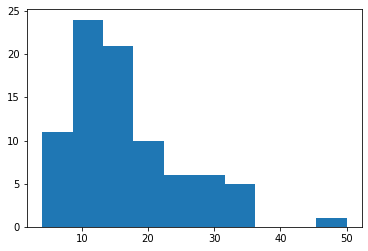

In [8]:
import matplotlib.pyplot as plt

plt.hist(survey['length'])

10 ~ 15文字あたりに Peak が見える。
比較的一言の Comment が多いアンケートの様子。

In [9]:
import MeCab # Libray の Import

tagger = MeCab.Tagger() # 初期化
text = 'すもももももももものうち' # 形態素解析を行なう文章を指定
words = tagger.parse(text) # 形態素解析を実施
words

'すもも\t名詞,一般,*,*,*,*,すもも,スモモ,スモモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nの\t助詞,連体化,*,*,*,*,の,ノ,ノ\nうち\t名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ\nEOS\n'

In [12]:
words = tagger.parse(text).splitlines()
words_arr = []

for i in words:
    if i == 'EOS': continue
    word_tmp = i.split()[0]
    words_arr.append(word_tmp)

words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']